#### **Regression-Analysis-Team-Project** by Team 1

# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
### Can you improve the algorithm that changed the world of real estate?

---
## 목차
#### 1. Data Introduce
#### 2. EDA(탐색적 데이터 분석)
#### 3. Feature Engineering
#### 4. Modeling
---

##### Importing necessary libraries

In [1]:
####### what's in startup file #######
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in 

In [2]:
####### what's not in startup file #######
from scipy import stats

# visualization in jupyter
%matplotlib inline   

# ignore warning messeges
import warnings
warnings.filterwarnings('ignore')

import time

##### Importing data
- Properties Data

In [3]:
prop16 = pd.read_csv('data/properties_2016.csv')
prop17 = pd.read_csv('data/properties_2017.csv')

- Train Data

In [4]:
train16 = pd.read_csv('data/train_2016_v2.csv', parse_dates=["transactiondate"])
train17 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])

- Submission Sample

In [5]:
submission_form = pd.read_csv('data/sample_submission.csv')

# **1. Data Introduce**

## 1.1 Purpose

#### 1. Target: log-error
- log-error between their Zestimate(house price estimation) and the actual sale price
- $logerror=log(Zestimate)−log(SalePrice)$

#### 2. Feature
- all given features of a home 

#### 3. Kaggle Submission
- properties에 대한 2016년 10/11월/12월 & 2017년 10/11/12월 6개 시점의 logerror를 예측
- 하지만 시계열 분석이 현 시점에서는 어렵기 때문에 2016년과 2017년의 예측치 두 값만을 내는 것을 목표로 함

## 1.2 Data set
- A full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California)

### 1) Properties data
- 구성
    - properties_2016.csv - all the properties with their home features for 2016
    - properties_2017.csv - all the properties with their home features for 2017
- Propertie data는 2016년과 2017년 모두 (2985217 * 58)로 shape이 동일함 
    - (2985217개의 집에 대한 58개 특징 변수)
- 2016년과 2017년 data의 parcelid는 완전히 동일함, 즉 두 데이터는 같은 집들에 대한 2개 년도의 집의 특징에 대한 자료임

In [6]:
print("shape of prop16: ", prop16.shape)
print("shape of prop17: ", prop17.shape)

shape of prop16:  (2985217, 58)
shape of prop17:  (2985217, 58)


In [7]:
# prop16과 prop17의 parcelid를 합쳤을 때 개수를 확인 (join="inner": 두 column에 다 있는 경우 결합)
id16 = prop16["parcelid"].rename(columns={"parcelid":"2016"})
id17 = prop16["parcelid"].rename(columns={"parcelid":"2017"})
id = pd.concat([id16, id17], axis=1, join='inner') 
print("shape of id: ", id.shape)
id[0][id[0]!=id[1]]    # 2016과 2017이 다를 때로 filtering

shape of id:  (2985217, 2)


Series([], Name: 0, dtype: int64)

### 2) Train data: 거래된 집에 대한 데이터
- parcelid, transaction date, logerror 3개 column으로 이루어짐
- 구성
    - train_2016.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    - train_2017.csv - the training set with transactions from 1/1/2017 to 9/15/2017    
- 2016년 data는 90275건의 거래를, 2017년 data는 77613건의 거래를 포함하고 있음 

In [8]:
print("shape of train16: ",train16.shape)
print("shape of train17: ",train17.shape)

shape of train16:  (90275, 3)
shape of train17:  (77613, 3)


### 3) Submission sample
- properties data에 있는 모든 집들의 6개 시점 logerror 예측치 작성

In [9]:
print("shape of submission_form: ", submission_form.shape)

shape of submission_form:  (2985217, 7)


# **2. EDA - Exploring the Data!**

## 2.1 Merging Train and Properties Data

### 1) 분석을 위해 하나의 Train Data로 만들기
1. 각 년도의 train data를 기준으로 properties data를 merge함 (거래마다 그 집의 특징을 properties에서 가져옴)
2. merge한 2016년 data와 2017년 data를 (위아래로) 연결함
3. 결과적으로 2016년~2017년의 모든 거래에 대해 해당하는 집의 특징을 merge한 하나의 train data가 구성됨
    - shape: (167888, 60)

In [10]:
# traing16을 기준으로 prop16을 merge
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")

In [11]:
# traing17을 기준으로 prop17을 merge
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")

In [12]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


In [13]:
print("shape of merged: ", merged.shape)

shape of merged:  (167888, 60)


### 2) Status of merged data
- merged data를 전체적으로 살펴보고 data format 등 인코딩을 바꿔줄 부분을 전처리함
- 그 결과 2016년&2017년의 167,888건의 거래에 대해 61개 변수를 가진 하나의 data가 만들어짐
    - 변수: logerror(target), 거래날짜(전체, 년, 월), properties data(해당 거래 년도의 data)
- 카테고리 타입 변수가 많고, 변수들의 missing value가 매우 많음

In [14]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index().tail()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
55,landtaxvaluedollarcnt,167851,NaN,NaN,NaN,NaN,NaN,288880,445645,22,83730,197776,355334,4.89522e+07,0.000220385,float64
56,taxamount,167843,NaN,NaN,NaN,NaN,NaN,5989.52,7214.73,19.92,2798.07,4501.04,6914.16,586639,0.000268036,float64
57,taxdelinquencyflag,4683,1,Y,4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972106,object
58,taxdelinquencyyear,4683,NaN,NaN,NaN,NaN,NaN,13.8272,2.42166,3,13,14,15,99,0.972106,float64
59,censustractandblock,167002,NaN,NaN,NaN,NaN,NaN,6.04939e+13,1.05414e+12,6.0371e+13,6.03731e+13,6.0376e+13,6.05904e+13,4.8303e+14,0.00527733,float64


##### Data의 format 등에 먼저 전처리를 해줄 수 있는 부분

In [15]:
# transaction date을 year와 month로 분리해 줌
merged['transaction_year'] = merged['transactiondate'].dt.year
merged['transaction_month'] = merged['transactiondate'].dt.month

# taxdelinquency는 "Y"를 True로 바꾸어 줌 (다른 dummy 변수들은 1이나 True로 되어 있음)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].replace('Y',True)

# taxdelinquencyyear는 4자리의 년도로 format을 맞춰줌
merged["taxdelinquencyyear"] = merged["taxdelinquencyyear"].apply(lambda x: x + 2000 if x <= 17 else x + 1900)

# 위도 경도를 원래 단위로 맞춰줌
merged["latitude"] = merged["latitude"]/1000000
merged["longitude"] = merged["longitude"]/1000000

##### categorical / numerical variable 구분하기

In [16]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate', 'transaction_year', 'transaction_month',
            'rawcensustractandblock', 'censustractandblock', 'fips',
            'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'architecturalstyletypeid', 'decktypeid', 'buildingclasstypeid', 'storytypeid',
            'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 28
number of numerical variables: 32


##### 카테고리 변수 중 float type이 많음 → 필요할 경우 str으로 바꿔주기
- str: 'architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid'
    - 일단 년도 변수는 계산 등의 조작 가능성을 고려해 바꿔주지 않음: 'assessmentyear', 'taxdelinquencyyear'
- boolean: 'pooltypeid10', 'pooltypeid2', 'pooltypeid7' (일단 숫자인 채로 둠)

In [17]:
def cat_to_str(column_name):
    merged[column_name] = merged[column_name].astype("str")
    merged[column_name][merged[column_name] == 'nan'] = np.nan

In [18]:
ls_c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock',
             'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
             'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
             'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid']

for var in ls_c_to_s:
    cat_to_str(var)

In [19]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08,0,int64
logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263,0,float64
transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,datetime64[ns]
airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560,0.999446,float64
bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64


## 2.2 Exploring Target Variable: logerror

### 1) logerror의 분포
- logerror의 평균은 약 0.01로 zestimation의 logerror는 평균적으로 0에 가까이 있음 (집값 예측이 대체로 잘 되고 있음)
- 대부분의 값들이 평균인 0 근처에 모여있고, 정규분포와 비슷한 형태를 보이지만 logerror가 상대적으로 큰 outliers들 존재
- logerror는 평균인 0 근처를 기준으로 음수와 양수 양방향으로 분포하고 있음
- 가격을 아주 낮게 예측하거나 높게 예측하는 일부분의 outlier 집들이 logerror를 낮추는 key일 것으로 추측해볼 수 있음

In [20]:
merged_des.loc[["logerror"], ['mean', 'std', 'min','25%', '50%', '75%', 'max']]

,mean,std,min,25%,50%,75%,max
logerror,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263


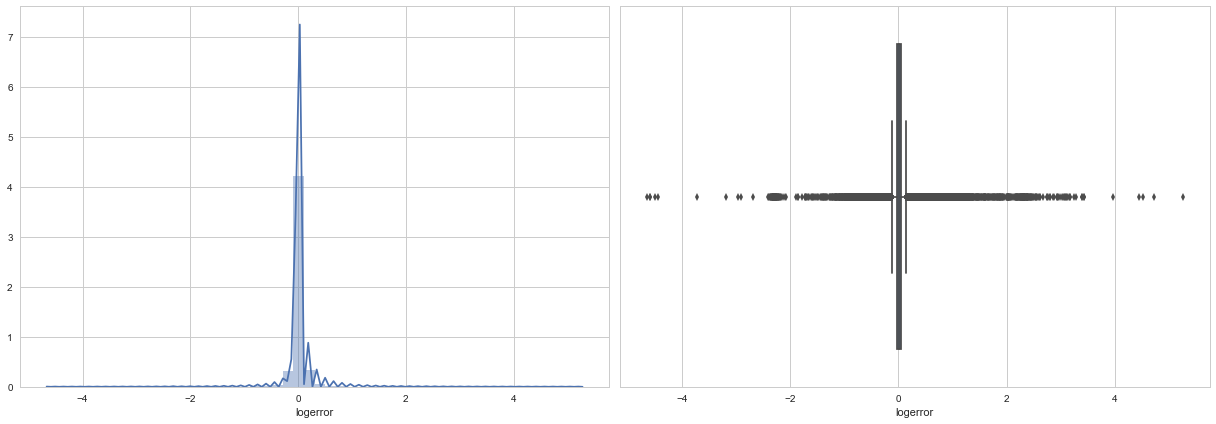

In [21]:
plt.figure(figsize=(17,6))

plt.subplot(121)
sns.distplot(merged["logerror"])

plt.subplot(122)
sns.boxplot(merged["logerror"])
plt.tight_layout()
plt.show()

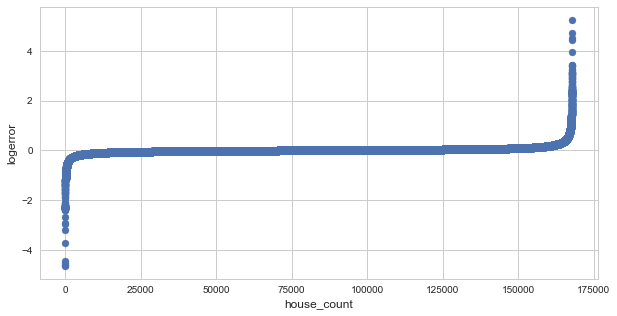

In [22]:
# logerror를 작은 값부터 정렬하여 분포를 살핌
plt.figure(figsize=(10,5))
plt.scatter(range(merged.shape[0]), np.sort(merged["logerror"]))
plt.xlabel('house_count', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

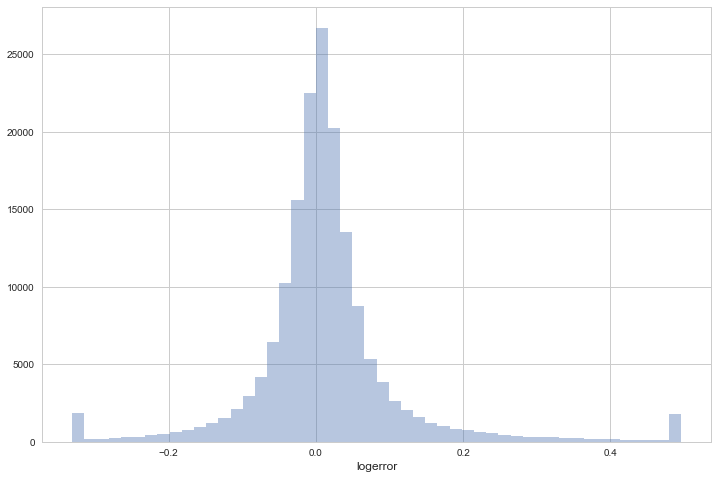

In [23]:
# 양 끝의 1%는 끝에 모아서 세워 그린 histogram
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].loc[merged['logerror']>ulimit] = ulimit
merged['logerror'].loc[merged['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(merged["logerror"], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

## 2.3 Exploring Feature Variables
- 독립변수를 주제별로 그룹지어 EDA
    - 변수의 의미, 분포를 파악
    - 적절한 missing value imputation 방안 
    - 추가적인 변수를 만들어낼 수 있는지 고민
- 주제별 분류
    1. 거래 날짜
    2. 집의 지리정보와 관련된 변수 (위도 경도 제외 카테고리 변수)
    3. 건물 특징, 타입 등에 대한 변수 (카테고리 변수)
    4. 집의 면적, 구조 등에 관련된 변수 (실수 변수 / 카테고리 변수)
    5. 세금과 관련된 변수 (실수 변수 / 카테고리 변수)    

### 1) 거래 관련 변수
- parcelid:
    - 대부분의 집들은 한번씩 거래됨 (거래횟수는 최대 3회까지 존재)
    - merged data의 167888개 row에서 unique한 parcelid의 개수는 165210개
- transactiondate

##### (1) parcelid: 집들은 몇번씩 거래되었나?

In [24]:
count = pd.DataFrame(columns=['count_all', 'count_2016', 'count_2017'])
count['count_all'] = (merged['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2016'] = (train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2017'] = (train17['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['index'] = ["1회", "2회", "3회"]
count.set_index("index")

,count_all,count_2016,count_2017
index,,,
1회,162541,90026,77218
2회,2660,123,193
3회,9,1,3


In [25]:
len(list(merged["parcelid"].unique()))

165210

##### (2) transactiondate: 시점별 거래량과 logerror분포는 어떠한가?

##### 연도 및 월별 거래량

In [26]:
transaction_2016_month = merged["transaction_month"][merged['transaction_year'] == 2016].value_counts().reset_index()
transaction_2016_month = transaction_2016_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2016_month['year']=2016

In [27]:
transaction_2017_month = merged["transaction_month"][merged['transaction_year'] == 2017].value_counts().reset_index()
transaction_2017_month = transaction_2017_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2017_month['year']=2017

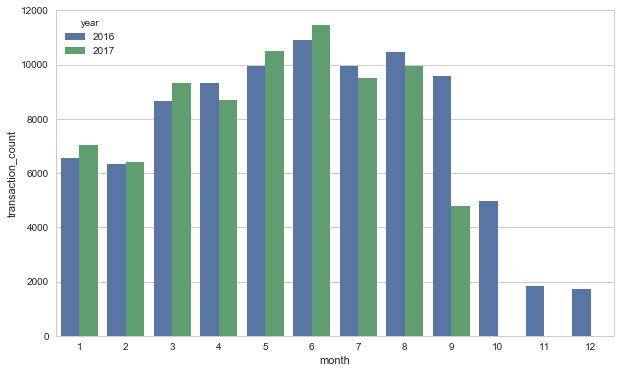

In [28]:
transaction_df = pd.concat([transaction_2016_month, transaction_2017_month]).reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.barplot(data=transaction_df, x="month",y="transaction_count", hue="year")
plt.show()

##### 연도 및 월별 logerror

In [29]:
transaction_logerror_df = merged[['logerror','transaction_year','transaction_month']]
transaction_logerror_df.tail()

,logerror,transaction_year,transaction_month
167883,-0.002245,2017,9
167884,0.020615,2017,9
167885,0.013209,2017,9
167886,0.037129,2017,9
167887,0.007204,2017,9


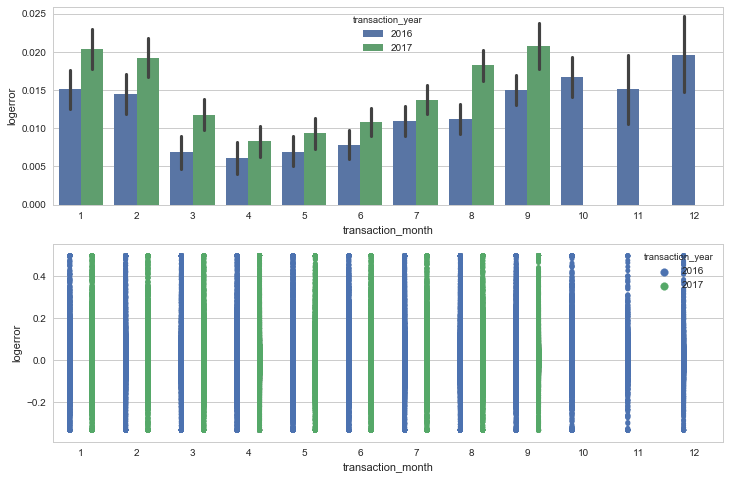

In [30]:
plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x = 'transaction_month', y = 'logerror', hue = "transaction_year", data = merged, ax = ax1)

ax2 = plt.subplot(2, 1, 2)
sns.stripplot(x = "transaction_month", y = "logerror", hue = "transaction_year",dodge=True, data = merged, ax = ax2)

plt.show()

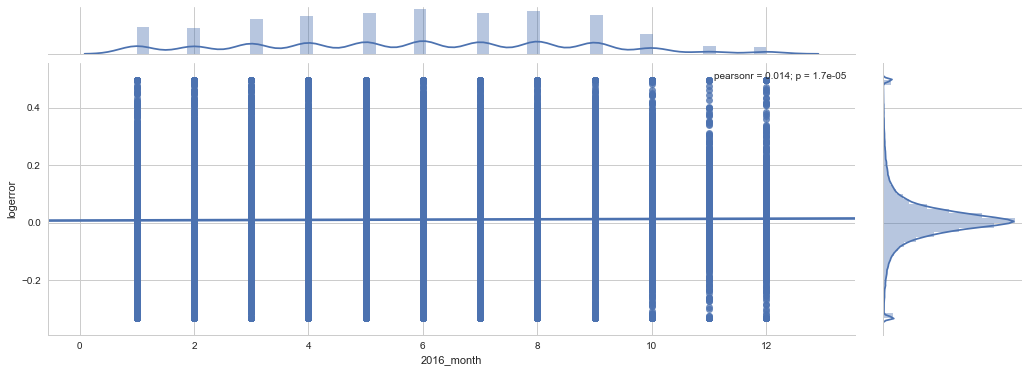

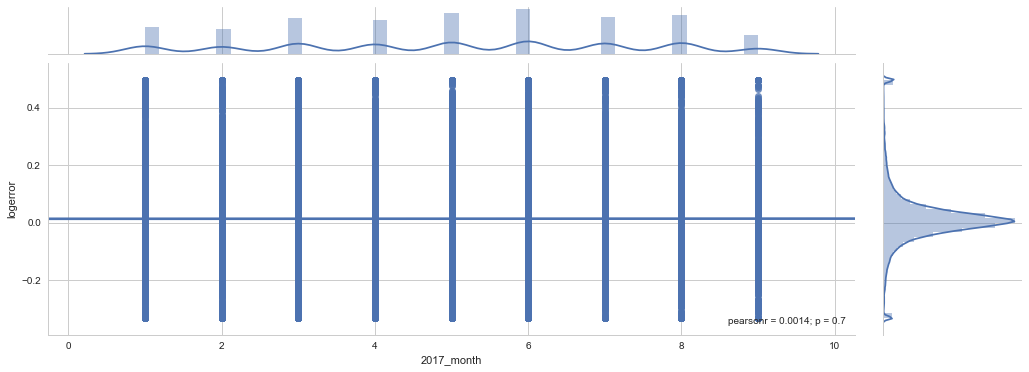

In [31]:
grid_1 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2016])\
.set_axis_labels("2016_month", "logerror")
grid_1.fig.set_size_inches(15, 5)

grid_2 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2017])\
.set_axis_labels("2017_month", "logerror")
grid_2.fig.set_size_inches(15, 5)

### 2) 집의 지리정보와 관련된 변수
- numerical variables: latitude, longitude
- categorical variables: fips, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood
    - county level 정보를 담고 있는 변수: fips, rawcensustractandblock와 censustractandblock의 앞 네 자리 코드
    - city level 이하의 정보를 담보 있는 변수: rawcensustractandblock와 censustractandblock의 5번째 자리 이후 코드, regionidcounty, regionidcity, regionidzip, regionidneighborhood

In [32]:
merged_des.loc[["fips","latitude", "longitude","rawcensustractandblock", "censustractandblock", "regionidcounty", "regionidcity",
                "regionidzip", "regionidneighborhood", "logerror"],["count", "mean", "min", "max", "dtype", "missing_ratio"]]

,count,mean,min,max,dtype,missing_ratio
fips,167854,NaN,NaN,NaN,object,0.000202516
latitude,167854,34.0068,33.3393,34.8188,float64,0.000202516
longitude,167854,-118.201,-119.475,-117.555,float64,0.000202516
rawcensustractandblock,167854,NaN,NaN,NaN,object,0.000202516
censustractandblock,167002,NaN,NaN,NaN,object,0.00527733
regionidcounty,167854,NaN,NaN,NaN,object,0.000202516
regionidcity,164579,NaN,NaN,NaN,object,0.0197096
regionidzip,167769,96586.4,95982,399675,float64,0.000708806
regionidneighborhood,66986,NaN,NaN,NaN,object,0.601008
logerror,167888,0.0139063,-4.65542,5.263,float64,0


##### latitude & longitude

In [33]:
merged[["latitude","longitude"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
latitude,167854.0,34.006778,0.265118,33.339295,33.812924,34.021700,34.173420,34.818767
longitude,167854.0,-118.201117,0.360059,-119.475416,-118.413025,-118.176852,-117.924692,-117.554636


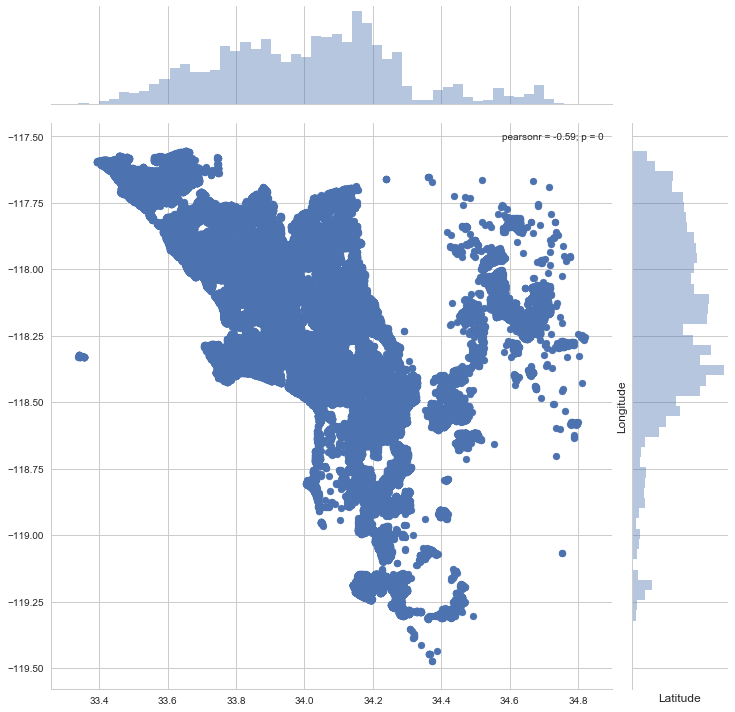

In [34]:
plt.figure(figsize=(8, 8))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

##### **(1) county level의 정보를 나타내는 변수들**
- fips & regionidcounty: 완전히 동일한 정보를 가짐
    - fips: 6037=Los Angeles, 6059=Orange, 6111=Ventura County (6=CA)
    - regionidcounty: 3101=Los Angeles, 1286=Orange, 2061=Ventura County
- censustractandblock & rawcensustractandblock의 앞 네자리: fips 값을 담고 있음
- 집들은 LA(가장 많음), Orange, Ventura(가장 적음) 순으로 분포되어 있음
- 위 변수들은 사실상 거의 동일한 정보를 가지고 있음

In [35]:
# cencus와 rawcensus의 앞 네자리로 변수를 만들고 다른 변수들과 묶기
merged["census_1"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:4])
merged["census_1"][merged["census_1"] == 'nan'] = np.nan
merged["raw_census_1"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:4])
merged["raw_census_1"][merged["raw_census_1"] == 'nan'] = np.nan
county_df = merged[["fips", "regionidcounty", "census_1", "raw_census_1","logerror"]].tail()
county_df.tail()

,fips,regionidcounty,census_1,raw_census_1,logerror
167883,6037.0,3101.0,6037,6037,-0.002245
167884,6037.0,3101.0,6037,6037,0.020615
167885,6111.0,2061.0,6111,6111,0.013209
167886,6037.0,3101.0,6037,6037,0.037129
167887,6037.0,3101.0,6037,6037,0.007204


In [36]:
# 변수별 분포
fips = merged["fips"].value_counts().reset_index().rename(columns={"index": "fips", "fips":"counts"})
regionidcounty = merged["regionidcounty"].value_counts().reset_index().rename(columns={"index": "regionidcounty", "regionidcounty":"counts"})
census_1 = merged["census_1"].value_counts().reset_index().rename(columns={"index": "census_1", "census_1":"counts"})
raw_census_1 = merged["raw_census_1"].value_counts().reset_index().rename(columns={"index": "raw_census_1", "raw_census_1":"counts"})
pd.concat([fips, regionidcounty, raw_census_1, census_1], axis=1)

,fips,counts,regionidcounty,counts,raw_census_1,counts,census_1,counts
0,6037.0,109270.0,3101.0,109270.0,6037,109270.0,6037,108757
1,6059.0,45136.0,1286.0,45136.0,6059,45136.0,6059,44894
2,6111.0,13448.0,2061.0,13448.0,6111,13448.0,6111,13340
3,NaN,NaN,NaN,NaN,NaN,NaN,6071,8
4,NaN,NaN,NaN,NaN,NaN,NaN,6065,2
5,NaN,NaN,NaN,NaN,NaN,NaN,4830,1


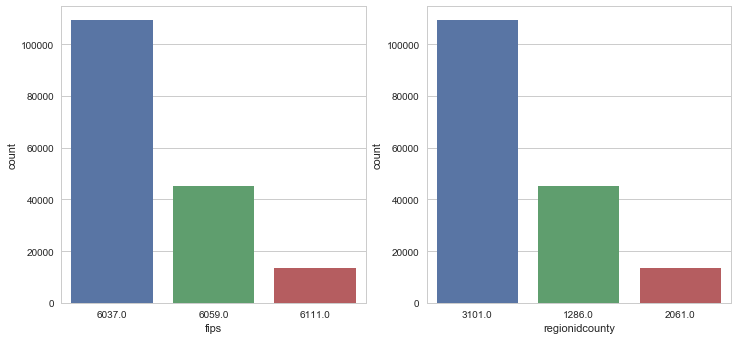

In [37]:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 2, 1)
sns.countplot(x = 'fips', data = merged, ax = ax1)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(x = 'regionidcounty', data = merged, ax = ax2)

##### **County보다 하위 level(더 작은 구역)의 정보를 나타내는 변수들**
- regionidcity: 179개 class
- census_2 & raw_census_2 (censustractandblock & rawcensustractandblock의 5-10의 여섯자리): census tract 값을 담고 있음 (유사한 인구적 특성을 가짐)
    - 3017개, 3024개 class
- regionidzip: 391개 class
    - 입력오류로 보이는 3396765는 NaN값 처리
- regionidneighborhood: 506개 class

In [38]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분: census tract → class가 3000개 이상이라 너무 많은 것으로 생각됨
merged["census_2"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:10])
merged["census_2"][merged["census_2"] == ""] = np.nan
census_2 = pd.DataFrame(merged["census_2"])
census_2 = census_2.groupby("census_2").size().reset_index(name='counts')

merged["raw_census_2"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:11])
merged["raw_census_2"][merged["raw_census_2"] == ""] = np.nan
raw_census_2 = pd.DataFrame(merged["raw_census_2"])
raw_census_2 = raw_census_2.groupby("raw_census_2").size().reset_index(name='counts')

In [39]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분 중 첫째 자리로 카테고리화 (카테고리 수를 줄임)
merged["census_3"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["census_3"][merged["census_3"] == ''] = np.nan
census_3 = pd.DataFrame(merged["census_3"])
census_3 = census_3.groupby("census_3").size().reset_index(name='counts')

merged["raw_census_3"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["raw_census_3"][merged["raw_census_3"] == ''] = np.nan
raw_census_3 = pd.DataFrame(merged["raw_census_3"])
raw_census_3 = raw_census_3.groupby("raw_census_3").size().reset_index(name='counts')

pd.concat([census_3, raw_census_3], axis=1)

,census_3,counts,raw_census_3,counts
0,0,55699,0,56037
1,1,24917,1,25077
2,2,16034,2,16086
3,3,3723,3,3719
4,4,20040,4,20181
5,5,19280,5,19312
6,6,8358,6,8391
7,7,2992,7,3011
8,8,2017,8,1977
9,9,13942,9,14063


In [40]:
# what is 6-digit zip code??? (CA zipcode는 9로 시작하는 5자리수) (http://www.zipcodestogo.com/California/)
print("number of houses of wierd zipcode:", len(merged["regionidzip"][merged["regionidzip"] >= 100000]))
merged[merged["regionidzip"] >= 100000].tail()   # zipcode가 이상한 집들의 데이터 확인

number of houses of wierd zipcode: 25


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,taxdelinquencyyear,censustractandblock,transaction_year,transaction_month,census_1,raw_census_1,census_2,raw_census_2,census_3,raw_census_3
146359,12969394,0.000630,2017-07-11,1.0,NaN,NaN,5.0,5.0,NaN,9.0,...,NaN,60374302001008.0,2017,7,6037,6037,430200,4302.00,4,4
153120,12969593,0.022602,2017-07-31,NaN,NaN,NaN,2.0,3.0,NaN,7.0,...,NaN,60374302001012.0,2017,7,6037,6037,430200,4302.00,4,4
160027,12969702,-0.126013,2017-08-24,1.0,NaN,NaN,3.0,4.0,NaN,8.0,...,NaN,60374302001057.0,2017,8,6037,6037,430200,4302.00,4,4
161938,12969611,-0.331138,2017-08-30,1.0,NaN,NaN,2.0,3.0,NaN,8.0,...,2015.0,NaN,2017,8,NaN,6037,NaN,4302.00,NaN,4
167393,12969775,0.035494,2017-09-15,1.0,NaN,NaN,3.0,5.0,NaN,7.0,...,NaN,60374302001027.0,2017,9,6037,6037,430200,4302.00,4,4


In [41]:
### 입력오류라고 보고 NaN값 처리
merged["regionidzip"][merged["regionidzip"]==399675] = np.nan

In [42]:
# regionidcity: 179개 클래스를 가진 카테고리 변수
print("number of unique city id:", len(merged["regionidcity"].unique()))

# census_2, raw_census_2: tract
print("class count of cencus_2(tract):", len(census_2["census_2"].unique()))
print("class count of raw_cencus_2(tract):", len(raw_census_2["raw_census_2"].unique()))

# census_3, raw_census_3: tract 첫 글자
print("class count of cencus_3(tract_1st):", len(census_3["census_3"].unique()))
print("class count of raw_cencus_3(tract_1st):", len(raw_census_3["raw_census_3"].unique()))

# regionidzip: 클래스가 391개인 카테고리 변수
print("number of unique zipcode:", len(merged["regionidzip"].unique()))

# regionidneighborhood: class 506개
print("number of unique regionidneighborhood:", len(merged["regionidneighborhood"].unique()))

number of unique city id: 179
class count of cencus_2(tract): 3017
class count of raw_cencus_2(tract): 3024
class count of cencus_3(tract_1st): 10
class count of raw_cencus_3(tract_1st): 10
number of unique zipcode: 390
number of unique regionidneighborhood: 506


##### Comment: 
- regionidcity: city id 숫자의미가 없는 카테고리 변수로 보아야할텐데 id의 종류가 179가지로 너무 많음
- censustractandblock & rawcensustractandblock의 tract: 5번째 자리 수로 카테고리화 해볼 수 있을 것 같음
- regionidcity, regionidneighborhood와 regionidzip의 경우 categorical 변수의 성격인 것 같은데 unique값이 너무 많은 것으로 보임
- suspicious한 zipcode가 발견됨: 입력오류로 생각하고 missing value로 처리해야겠음
- regionidneighborhood는 missing value가 60%로 꽤 높은데, imputation하기 어려울 것 같음

- 위치, 지리 변수 정리

In [43]:
merged.loc[:,["latitude", "longitude","fips", "regionidcounty", "raw_census_1", "census_1", "raw_census_2", "census_2", "raw_census_3", "census_3", "regionidcity",
                "regionidzip", "regionidneighborhood", "logerror"]].describe(include="all")

,latitude,longitude,fips,regionidcounty,raw_census_1,census_1,raw_census_2,census_2,raw_census_3,census_3,regionidcity,regionidzip,regionidneighborhood,logerror
count,167854.000000,167854.000000,167854,167854,167854,167002,167854,167002,167854,167002,164579,167744.000000,66986,167888.000000
unique,NaN,NaN,3,3,3,6,3024,3017,10,10,178,NaN,505,NaN
top,NaN,NaN,6037.0,3101.0,6037,6037,0524.20,052420,0,0,12447.0,NaN,27080.0,NaN
freq,NaN,NaN,109270,109270,109270,108757,455,444,56037,55699,38562,NaN,1476,NaN
mean,34.006778,-118.201117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96541.219418,NaN,0.012252
std,0.265118,0.360059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,412.110902,NaN,0.102568
min,33.339295,-119.475416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95982.000000,NaN,-0.331138
25%,33.812924,-118.413025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96193.000000,NaN,-0.025300
50%,34.021700,-118.176852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96389.000000,NaN,0.006000
75%,34.173420,-117.924692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96987.000000,NaN,0.039200


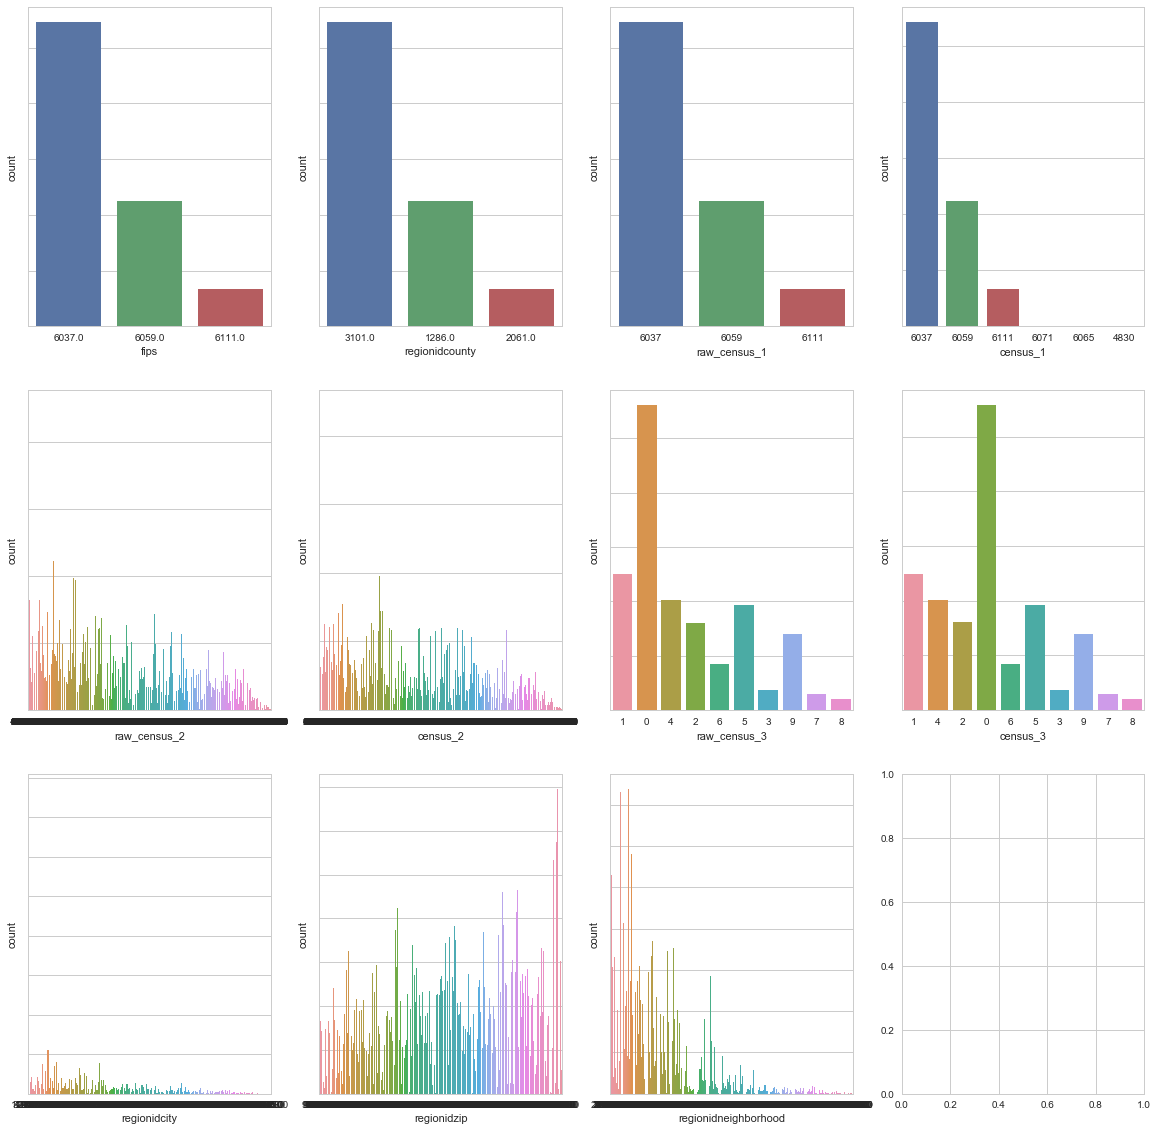

In [44]:
geo_cat = ["fips", "regionidcounty", "raw_census_1", "census_1", "raw_census_2", "census_2", "raw_census_3", "census_3", "regionidcity",
                "regionidzip", "regionidneighborhood"]
fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.countplot(x = n, data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

#### **2) 건물 특징, 타입 등에 대한 변수들**
- 전체 리스트: architecturalstyletypeid, decktypeid, buildingqualitytypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

In [45]:
merged_des.loc[["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
              "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
decktypeid,1272,1,66.0,1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992424,object
buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64
buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
storytypeid,93,1,7.0,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999446,object
typeconstructiontypeid,522,4,6.0,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996891,object
propertycountylandusecode,167853,90,0100,57628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000208472,object
propertylandusetypeid,167854,14,261.0,113078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000202516,object
propertyzoningdesc,108789,2346,LAR1,14444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352014,object


- 건물의 특징 등에 대한 카테고리 변수들인데, missing value가 99% 이상인 값들이 많음

- **architecturalstyletypeid**
    - 집의 건축 스타일에 대한 1부터 27까지 categorical data
    - 27가지 class 중에 6가지 값이 나옴

In [46]:
architecturalstyletypeid = pd.DataFrame(merged["architecturalstyletypeid"])
architecturalstyletypeid.groupby("architecturalstyletypeid").size().reset_index(name='counts')

,architecturalstyletypeid,counts
0,10.0,1
1,2.0,16
2,21.0,15
3,3.0,7
4,7.0,394
5,8.0,35


- **decktypeid**
    - deck이 있는 경우 deck의 type, but data dict.에 type 분류 설명이 없어 66이 뭘 말하는지 알 수 없음
    - missing value ratio: 0.992424

In [47]:
decktypeid = pd.DataFrame(merged["decktypeid"])
decktypeid.groupby("decktypeid").size().reset_index(name='counts')

,decktypeid,counts
0,66.0,1272


- **buildingqualitytypeid**
    - Overall assessment of condition of the building from best (lowest) to worst (highest)
    - missing value ratio: 0.36164

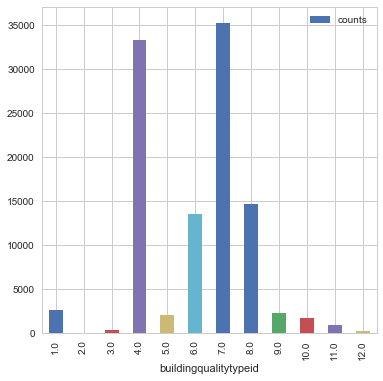

In [48]:
buildingqualitytypeid = pd.DataFrame(merged["buildingqualitytypeid"])
buildingqualitytypeid_count = buildingqualitytypeid.groupby("buildingqualitytypeid").size().reset_index(name='counts')
buildingqualitytypeid_count.plot(x = 'buildingqualitytypeid', y = 'counts', kind = 'bar', figsize=(6, 6))
plt.show()

- **buildingclasstypeid**
    - 건물이 fireproofed한 frame(non-combustible)를 갖고 있는지 분류 (0-5 cateogories, 5=non of above)
    - missing value ratio: 0.999815

In [49]:
buildingclasstypeid = pd.DataFrame(merged["buildingclasstypeid"])
buildingclasstypeid.groupby("buildingclasstypeid").size().reset_index(name='counts')

,buildingclasstypeid,counts
0,3.0,1
1,4.0,30


- **storytypeid**
    - Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.)
    - missing value ratio: 0.999446

In [50]:
storytypeid = pd.DataFrame(merged["storytypeid"])
storytypeid.groupby("storytypeid").size().reset_index(name='counts')

,storytypeid,counts
0,7.0,93


- **typeconstructiontypeid**
    - What type of construction material was used to construct the home
    - missing value ratio: 0.996891

In [51]:
typeconstructiontypeid = pd.DataFrame(merged["typeconstructiontypeid"])
typeconstructiontypeid.groupby("typeconstructiontypeid").size().reset_index(name='counts')

,typeconstructiontypeid,counts
0,10.0,1
1,13.0,2
2,4.0,3
3,6.0,516


- **propertycountylandusecode**
    - County land use code i.e. it's zoning at the county level
    - 숫자와 알파벳으로 이루어진 1~4자리 문자열
    - 90개 class

In [52]:
merged["propertycountylandusecode"].unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '010V', '1116', '01HC', '010G', '0300', '010F', '1117',
       '0103', '38', '1210', '0111', '010M', '96', '135', '0108', '1014',
       '1112', '0201', '0109', '1310', '010H', '1410', '1222', '1321',
       '1720', '1011', '1432', '0401', '0102', '012D', '73', '105',
       '0110', '100V', '0130', '8800', '0303', '0210', '1012', '1333',
       '0114', '01DD', '020G', '040A', '012E', '020M', '040V', '070D',
       '1200', '030G', '1722', '6050', '1421', '010', nan, '200', '0',
       '1420', '0131', '0301', '01HE', '0204', '0113', '0133', '040G',
       '1120', '0105', '0141', '0115', '010L', '040B', '0203', '020E'],
      dtype=object)

In [53]:
propertycountylandusecode = pd.DataFrame(merged["propertycountylandusecode"])
propertycountylandusecode_count = propertycountylandusecode.groupby("propertycountylandusecode").size().reset_index(name='counts')

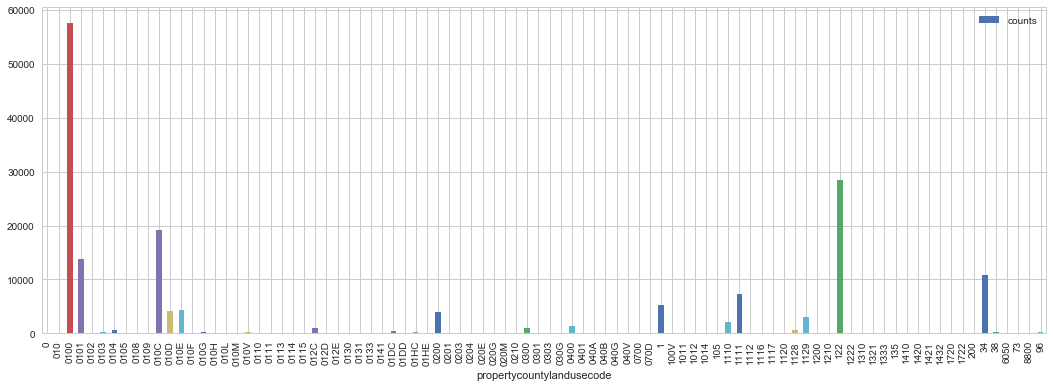

In [54]:
propertycountylandusecode_count.plot(x = 'propertycountylandusecode', y = 'counts', kind = 'bar', figsize=(18, 6))

- **propertylandusetypeid**
    - Type of land use the property is zoned for
    - 261 Single Family Residential과 266 Condominium이 데이터의 대부분을 차지함

In [55]:
propertylandusetypeid = pd.DataFrame(merged["propertylandusetypeid"])
propertylandusetypeid = propertylandusetypeid.groupby("propertylandusetypeid").size().reset_index(name='counts')
propertylandusetypeid

,propertylandusetypeid,counts
0,246.0,4397
1,247.0,1168
2,248.0,1608
3,260.0,104
4,261.0,113078
5,263.0,158
6,264.0,17
7,265.0,691
8,266.0,42157
9,267.0,57


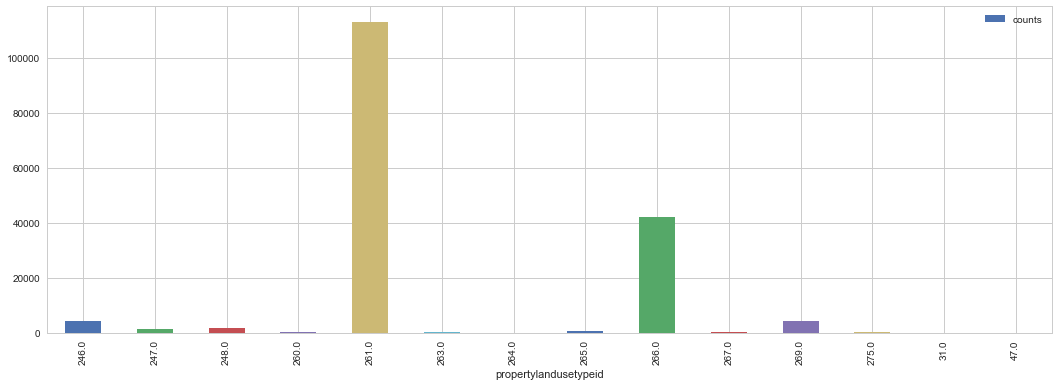

In [56]:
propertylandusetypeid.plot(x = 'propertylandusetypeid', y = 'counts', kind = 'bar', figsize=(18, 6))

- **propertyzoningdesc**
    - Description of the allowed land uses (zoning) for that property
        - Zoning affects what you can and cannot do with a property
    - 알파벳과 숫자로 이루어진 문자열
    - 2347개 unique값, grouping을 해서 카테고리 class를 줄인 class를 만들어 봄
    - 주마다 zoning 규칙이 있지만 대체로 R이 residential, c는 commercial, I/M은 industrial 등으로 구분되어 있음
    - 코드를 살펴보면 앞의 두자리는 지역을 나타내는 것으로 추측
    - 첫번째 글자로 묶거나, 세번째자리 글자로 묶어 새로운 변수 두 가지를 만들어 봄
    - LA: https://library.municode.com/ca/los_angeles_county/codes/code_of_ordinances?nodeId=TIT22PLZO_DIV1PLZO_CH22.12ZODI_22.12.010ZODEURTAAU
    - Orange: https://library.municode.com/ca/orange/codes/code_of_ordinances?nodeId=TIT17ZO_CH17.06ZODIMA
    - Ventura: https://docs.vcrma.org/images/pdf/planning/ordinances/VCNCZO_Current.pdf
    

In [57]:
print("number of unique values:", len(merged["propertyzoningdesc"].unique()))
merged_des.loc["propertyzoningdesc"].reset_index().loc[[0, 13, 14], :]

number of unique values: 2347


,index,propertyzoningdesc
0,count,108789
13,missing_ratio,0.352014
14,dtype,object


In [58]:
pd.DataFrame(merged["propertyzoningdesc"].unique()).tail()

,0
2342,GARR-MD
2343,DUR120000*
2344,LCRA 7500*
2345,LCRA7000-R
2346,BFA15000*


In [59]:
propertyzoningdesc = merged["propertyzoningdesc"].value_counts().reset_index().rename(columns={"index": "propertyzoningdesc", "propertyzoningdesc":"counts"})
propertyzoningdesc.head()

,propertyzoningdesc,counts
0,LAR1,14444
1,LAR3,5251
2,LARS,2897
3,LBR1N,2684
4,LARD1.5,2437


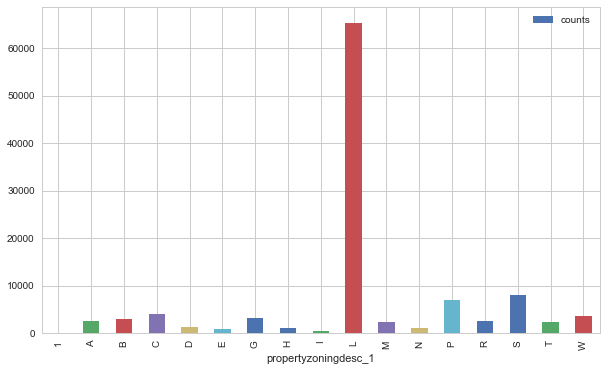

In [60]:
# 첫글자로 새로운 변수 만들기 (첫 글자로 카테고리화)
merged["propertyzoningdesc_1"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[:1])
merged["propertyzoningdesc_1"][merged["propertyzoningdesc_1"] == "n"] = np.nan
propertyzoningdesc_1 = pd.DataFrame(merged["propertyzoningdesc_1"])
propertyzoningdesc_1 = propertyzoningdesc_1.groupby("propertyzoningdesc_1").size().reset_index(name='counts')
propertyzoningdesc_1.plot(x = 'propertyzoningdesc_1', y = 'counts', kind = 'bar', figsize=(10, 6))
plt.show()

In [61]:
# merged["propertyzoningdesc_3"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[2:3])
# merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == "n"] = np.nan
# propertyzoningdesc_3 = pd.DataFrame(merged["propertyzoningdesc_3"])
# propertyzoningdesc_3 = propertyzoningdesc_1.groupby("propertyzoningdesc_3").size().reset_index(name='counts')
# propertyzoningdesc_3.plot(x = 'propertyzoningdesc_3', y = 'counts', kind = 'bar', figsize=(10, 6))
# plt.show()

##### Comment:
- missing value가 너무 높은 변수들: architecturalstyletypeid, decktypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc
- 집과 구역의 용도 등을 나타내는 변수들: propertycountylandusecode, propertylandusetypeid, propertyzoningdesc
- buildingqualitytypeid: 분포는 4(좋은 편), 7(중간)에 많이 모여있음 → 어떤 값으로 imputation을 해야할 지 고민

##### building 특성을 나타내는 변수의 분포 정리

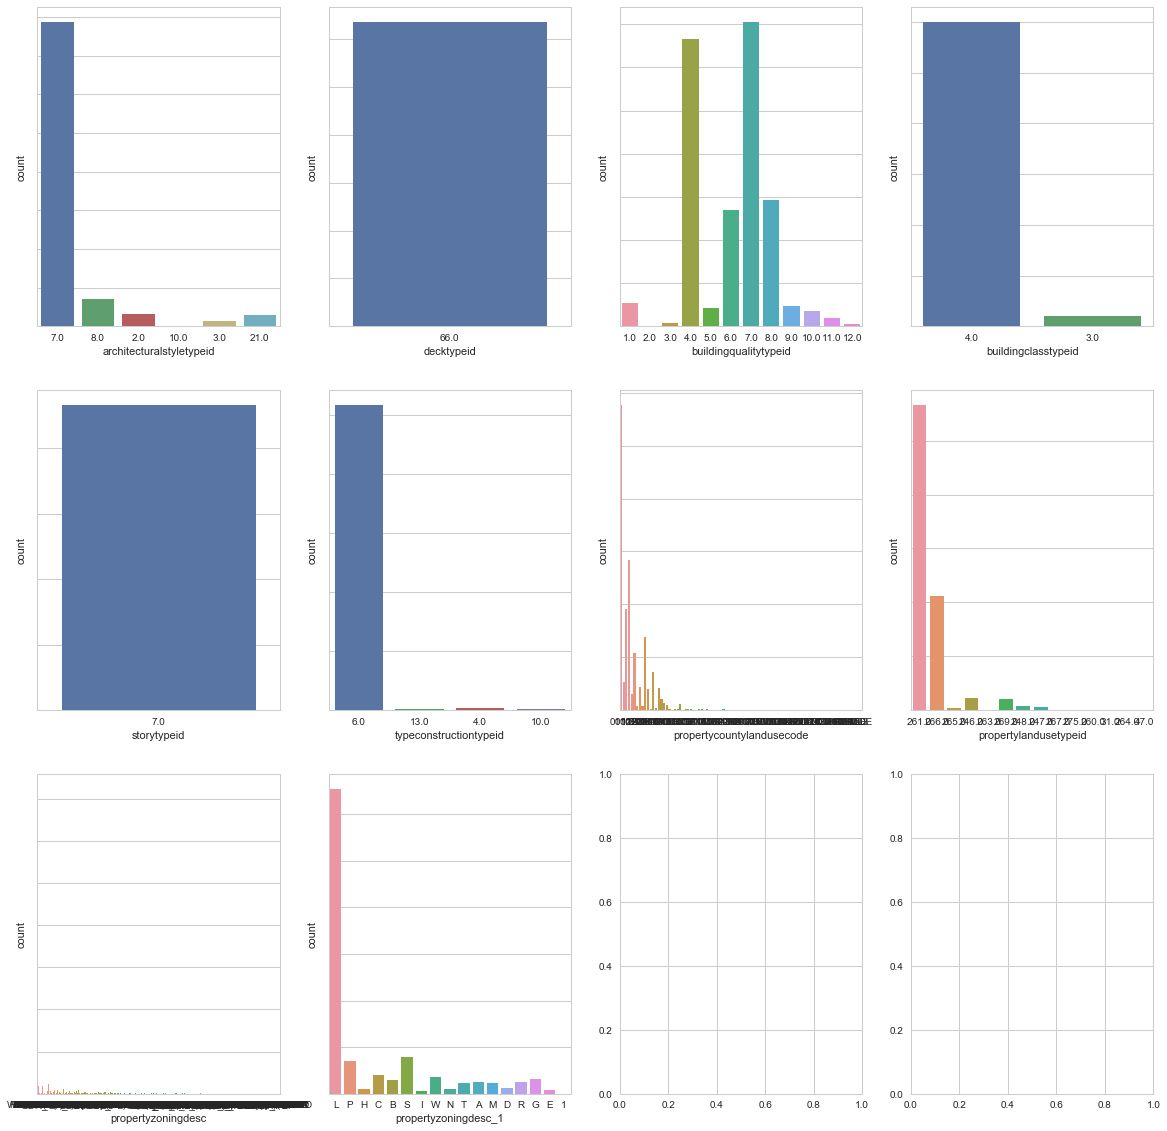

In [62]:
bdg_var = ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
           "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc", "propertyzoningdesc_1"]
fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_var):
    sns.countplot(x = n, data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

## 2.3 Exploring Feature Variables
- 독립변수를 주제별로 그룹지어 EDA
    - 변수의 의미, 분포를 파악
    - 적절한 missing value imputation 방안 
    - 추가적인 변수를 만들어낼 수 있는지 고민
- 주제별 분류
    1. 거래 날짜
    2. 집의 지리정보와 관련된 변수 (위도 경도 제외 카테고리 변수)
    3. 건물 특징, 타입 등에 대한 변수 (카테고리 변수)
    4. 집의 구조, 유틸, 면적 등에 관련된 변수 (실수 변수 / 카테고리 변수)
    5. 세금과 관련된 변수 (실수 변수 / 카테고리 변수)    

### 4. 집의 구조, 유틸, 면적 등에 관련된 변수 (실수 변수 / 카테고리 변수)
- numerical variables: <br/>bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt, fireplacecnt, poolcnt, basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet<br/>
<br/>
- categorical variables:<br/> fips, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood, heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, pooltypeid10, pooltypeid2, pooltypeid7

#### 4-1. 집 구조 관련 변수

In [63]:
merged_des.loc[["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt", "numberofstories", "roomcnt", "bedroomcnt", "unitcnt", "yearbuilt"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
calculatedbathnbr,166056,NaN,NaN,NaN,NaN,NaN,2.31254,0.977808,1,2,2,3,20,0.010912,float64
threequarterbathnbr,22115,NaN,NaN,NaN,NaN,NaN,1.00913,0.109294,1,1,1,1,7,0.868275,float64
fullbathcnt,166056,NaN,NaN,NaN,NaN,NaN,2.24534,0.964703,1,2,2,3,20,0.010912,float64
numberofstories,38169,NaN,NaN,NaN,NaN,NaN,1.43776,0.544508,1,1,1,2,6,0.772652,float64
roomcnt,167854,NaN,NaN,NaN,NaN,NaN,1.47748,2.8215,0,0,0,0,18,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
unitcnt,109056,NaN,NaN,NaN,NaN,NaN,1.11037,0.988168,1,1,1,1,237,0.350424,float64
yearbuilt,166828,NaN,NaN,NaN,NaN,NaN,1968.57,23.7772,1824,1953,1970,1987,2016,0.00631373,float64


- missing value ratio가 특히 높은 변수는 "threequarterbathnbr"과 "numberofstories", 그리고 "unitcnt"

##### bathroom 관련 변수들
- fullbath란 tub까지 모두 갖춘 화장실, 3/4 bath란 tub이 없고 샤워부스만 있는 화장실, half bath는 변기와 세면대만 있는 화장실을 말함
- bathroomcnt와 calculatedbathnbr: Number of bathrooms in home including fractional bathrooms(=0.5?)
- threequarterbathnbr: missing value 높음 (imputation: 0 or 1)
- fullbathcnt

In [64]:
bathroomcnt = pd.DataFrame(merged["bathroomcnt"])
bathroomcnt = bathroomcnt.groupby("bathroomcnt").size().reset_index(name='counts')

In [65]:
calculatedbathnbr = pd.DataFrame(merged["calculatedbathnbr"])
calculatedbathnbr = calculatedbathnbr.groupby("calculatedbathnbr").size().reset_index(name='counts')

In [66]:
threequarterbathnbr = pd.DataFrame(merged["threequarterbathnbr"])
threequarterbathnbr = threequarterbathnbr.groupby("threequarterbathnbr").size().reset_index(name='counts')

In [67]:
fullbathcnt = pd.DataFrame(merged["fullbathcnt"])
fullbathcnt = fullbathcnt.groupby("fullbathcnt").size().reset_index(name='counts')

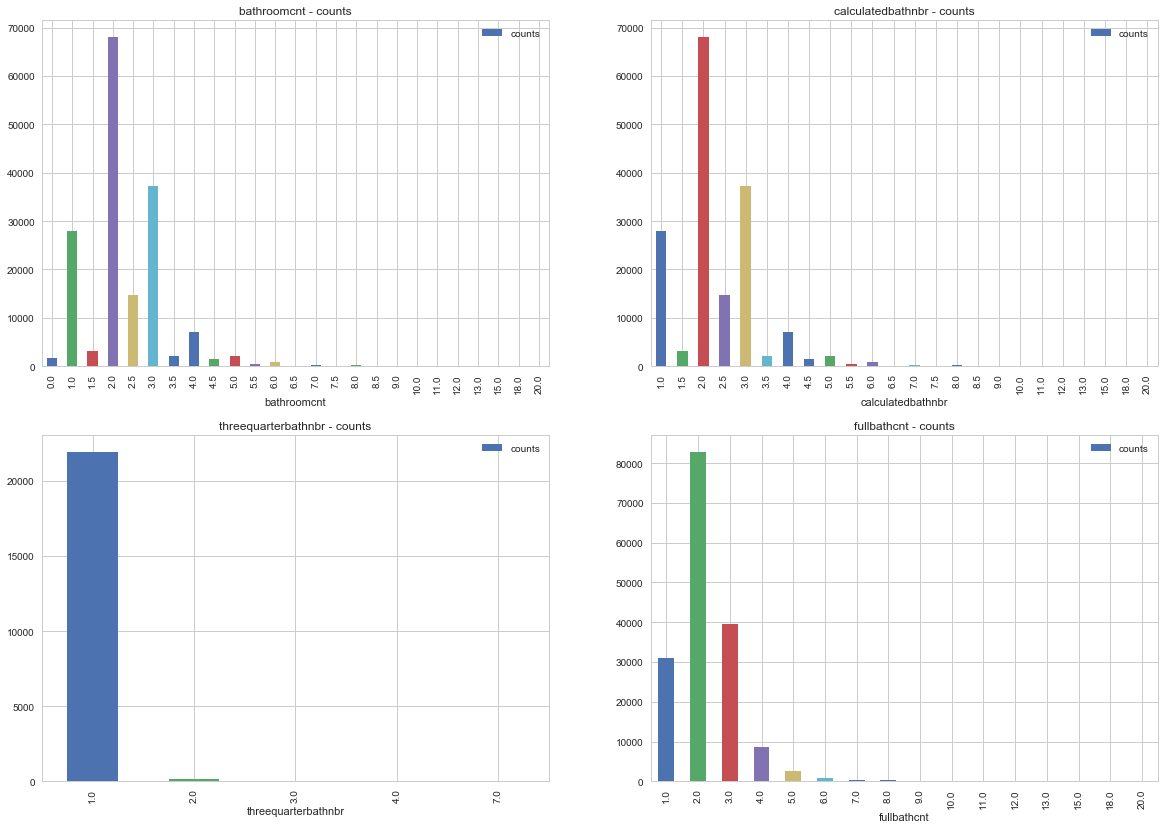

In [68]:
plt.figure(figsize=(20,14))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((2,2), (0,0))
bathroomcnt.plot(x = 'bathroomcnt', y = 'counts', kind = 'bar', ax=ax1)
ax1.set_title('bathroomcnt - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((2,2), (0,1))
calculatedbathnbr.plot(x = 'calculatedbathnbr', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((2,2), (1,0))
threequarterbathnbr.plot(x = 'threequarterbathnbr', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

# Graph for fullbathcnt - counts
ax4 = plt.subplot2grid((2,2), (1,1))
fullbathcnt.plot(x = 'fullbathcnt', y = 'counts', kind = 'bar', ax=ax4)
ax4.set_title('fullbathcnt - counts')
plt.show()

##### Numberofstories
- 최빈값인 1로 imputation 할 수 있겠음 (보통은 1층집)

In [69]:
numberofstories = pd.DataFrame(merged["numberofstories"])
numberofstories = numberofstories.groupby("numberofstories").size().reset_index(name='counts')

##### roomcnt & bedroomcnt
- roomcnt: Total number of rooms in the principal residence
    - 0이 많다는 점이 특징

In [70]:
roomcnt = pd.DataFrame(merged["roomcnt"])
roomcnt = roomcnt.groupby("roomcnt").size().reset_index(name='counts')

In [71]:
bedroomcnt = pd.DataFrame(merged["bedroomcnt"])
bedroomcnt = bedroomcnt.groupby("bedroomcnt").size().reset_index(name='counts')

In [72]:
# df_rooms = pd.concat([feet_df_desc.loc['roomcnt'], feet_df_desc.loc['bedroomcnt']], axis=1)
# df_rooms
merged_des.loc[["roomcnt", "bedroomcnt"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
roomcnt,167854,NaN,NaN,NaN,NaN,NaN,1.47748,2.8215,0,0,0,0,18,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64


##### unitcnt
- imputation: 최빈값인 1로 할 수 있겠음 (대부분 집은 1가구)

In [73]:
unitcnt = pd.DataFrame(merged["unitcnt"])
unitcnt = unitcnt.groupby("unitcnt").size().reset_index(name='counts')

##### yearbuilt

In [74]:
yearbuilt = pd.DataFrame(merged["yearbuilt"])
yearbuilt = yearbuilt.groupby("yearbuilt").size().reset_index(name='counts')

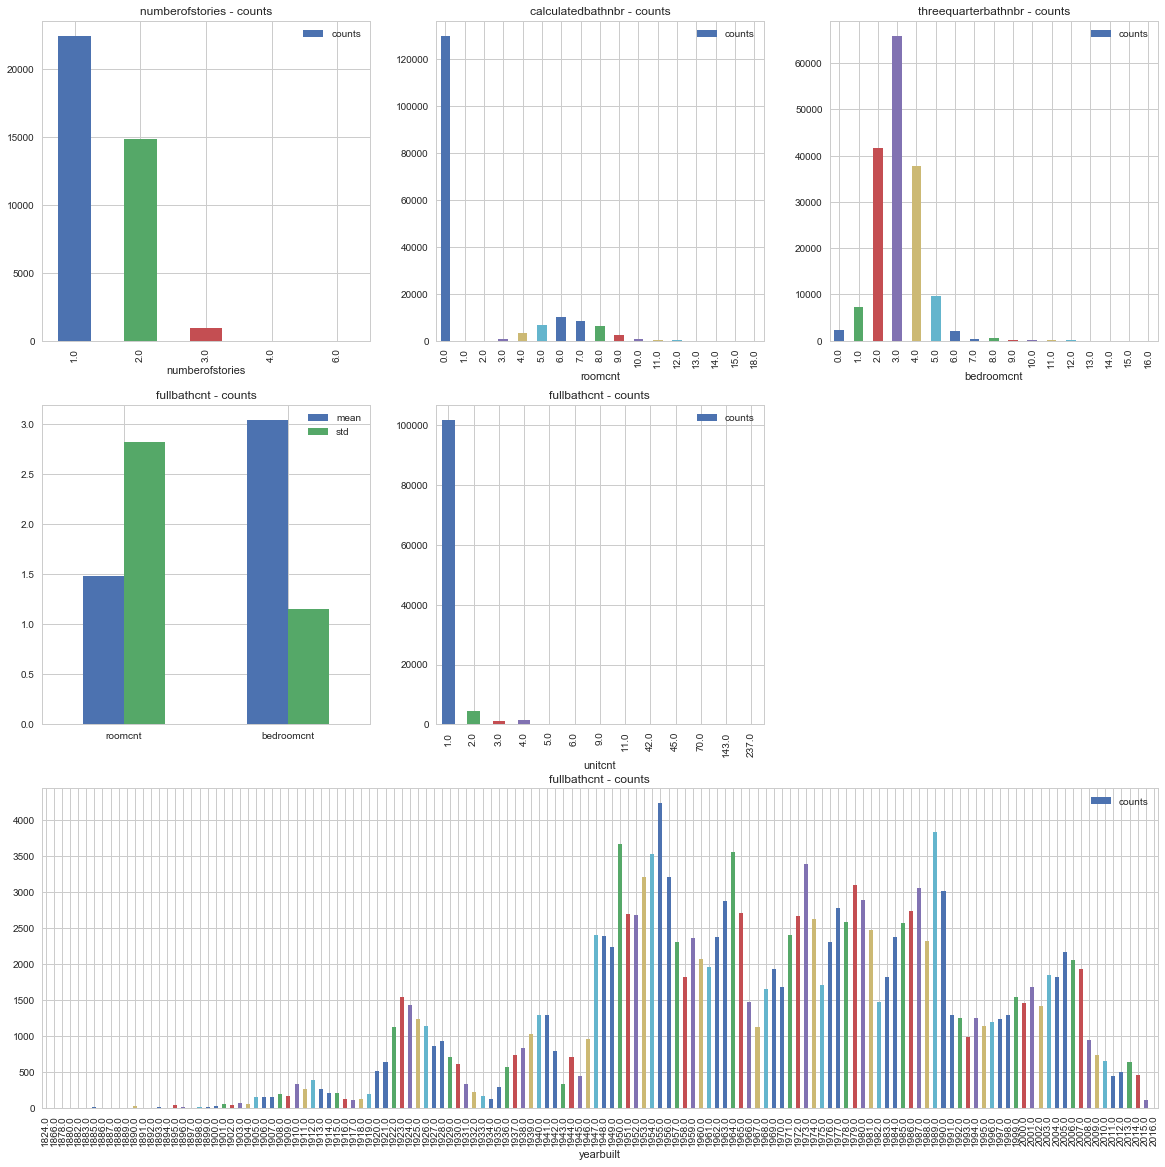

In [151]:
plt.figure(figsize=(20,20))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((3,3), (0,0))
numberofstories.plot(x = 'numberofstories', y = 'counts', kind = 'bar' , ax=ax1)
ax1.set_title('numberofstories - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((3,3), (0,1))
roomcnt.plot(x = 'roomcnt', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((3,3), (0,2))
bedroomcnt.plot(x = 'bedroomcnt', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

# Graph for fullbathcnt - counts
ax4 = plt.subplot2grid((3,3), (1,0), colspan = 1)
merged_des.loc[["roomcnt", "bedroomcnt"],["mean","std"]].plot.bar(rot=0, ax=ax4)
ax4.set_title('fullbathcnt - counts')

# Graph for fullbathcnt - counts
ax5 = plt.subplot2grid((3,3), (1,1), colspan = 1)
unitcnt.plot(x = 'unitcnt', y = 'counts', kind = 'bar', ax=ax5)
ax5.set_title('fullbathcnt - counts')

# Graph for fullbathcnt - counts
ax6 = plt.subplot2grid((3,3), (2,0), colspan = 3)
yearbuilt.plot(x = 'yearbuilt', y = 'counts', kind = 'bar', ax=ax6)
ax6.set_title('fullbathcnt - counts')

plt.show()

#### **4-2. 집의 기타 특징(유틸리티 등)에 대한 변수들**

In [76]:
merged_des.loc[["heatingorsystemtypeid", "airconditioningtypeid", "hashottuborspa", "fireplacecnt", "fireplaceflag", "poolcnt",
                "poolsizesum", "pooltypeid10", "pooltypeid2", "pooltypeid7"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
heatingorsystemtypeid,105651,12,2.0,71936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.370705,object
airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
hashottuborspa,3904,1,True,3904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976746,object
fireplacecnt,17896,NaN,NaN,NaN,NaN,NaN,1.18943,0.487327,1,1,1,1,5,0.893405,float64
fireplaceflag,394,1,True,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997653,object
poolcnt,34075,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1,0.797037,float64
poolsizesum,1838,NaN,NaN,NaN,NaN,NaN,518.931,155.733,24,420,500,600,1750,0.989052,float64
pooltypeid10,1626,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1,0.990315,float64
pooltypeid2,2278,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1,0.986431,float64
pooltypeid7,31776,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1,0.810731,float64


- missing value ratio가 높은 변수들이 많음
- pool 관련 변수, fireplace, hot tub or spa는 NaN 값은 없는 경우로 보아 0으로 imputation
- heating system, airconditioning type은 imputation이 애매한 경우

##### heatingorsystemtypeid & airconditioningtypeid
- 난방과 에어컨 타입에 대한 카테고리 변수
- 난방: 2-Central, 7-Floor/Wall, 13-None, 24-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 2로 imputation 가능
    - 혹은 13과 NaN을 0으로, 나머지는 1로 하여 heating_flag 같은 변수로 만들 수 있음
- 에어컨: 1-Central, 5-None, 11-Wall unit, 13-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 1로 imputation 가능
    - 혹은 5과 NaN을 0으로, 나머지는 1로 하여 aircond_flag 같은 변수로 만들 수 있음
- 하지만 난방의 37%와 에어컨의 68%를 '없다'고 가정하는 것은 무리가 있어 보임

In [77]:
heatingorsystemtypeid = pd.DataFrame(merged["heatingorsystemtypeid"])
heatingorsystemtypeid = heatingorsystemtypeid.groupby("heatingorsystemtypeid").size().reset_index(name='counts')

In [78]:
airconditioningtypeid = pd.DataFrame(merged["airconditioningtypeid"])
airconditioningtypeid = airconditioningtypeid.groupby("airconditioningtypeid").size().reset_index(name='counts')

##### fireplacecnt & fireplaceflag
- NaN값은 없는 경우라고 간주, 0으로 imputation

In [79]:
fireplacecnt = pd.DataFrame(merged["fireplacecnt"])
fireplacecnt = fireplacecnt.groupby("fireplacecnt").size().reset_index(name='counts')

In [80]:
fireplaceflag = pd.DataFrame(merged["fireplaceflag"])
fireplaceflag = fireplaceflag.groupby("fireplaceflag").size().reset_index(name='counts')
fireplaceflag

,fireplaceflag,counts
0,True,394


##### pool 관련 변수들
- poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, hashottuborspa
- 이 변수들은 NaN 값을 없는 경우로 간주, 0으로 imputation

In [81]:
# poolcnt: pool의 개수
pd.DataFrame(merged['poolcnt'].value_counts().sort_index())

,poolcnt
1.0,34075


In [82]:
# hashottuborspa: Does the home have a hot tub or spa
pd.DataFrame(merged['hashottuborspa'].value_counts().sort_index())

,hashottuborspa
True,3904


In [83]:
# pooltypeid10: Spa or Hot Tub
pd.DataFrame(merged['pooltypeid10'].value_counts().sort_index())

,pooltypeid10
1.0,1626


In [84]:
# pooltypeid7: Pool without hot tub
pd.DataFrame(merged['pooltypeid2'].value_counts().sort_index())

,pooltypeid2
1.0,2278


In [85]:
pd.DataFrame(merged['pooltypeid7'].value_counts().sort_index())

,pooltypeid7
1.0,31776


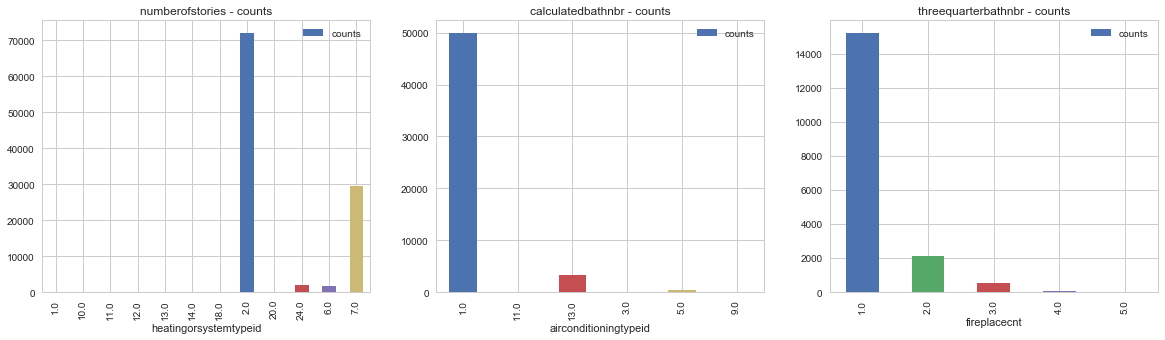

In [86]:
plt.figure(figsize=(20,5))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((1,3), (0,0))
heatingorsystemtypeid.plot(x = 'heatingorsystemtypeid', y = 'counts', kind = 'bar', ax=ax1)
ax1.set_title('numberofstories - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((1,3), (0,1))
airconditioningtypeid.plot(x = 'airconditioningtypeid', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((1,3), (0,2))
fireplacecnt.plot(x = 'fireplacecnt', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

plt.show()

#### **4-3) 집의 면적에 대한 변수들**
- basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet

In [87]:
merged_des.loc[["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
                "finishedsquarefeet12", "finishedsquarefeet13","finishedsquarefeet15","finishedsquarefeet50",
                "yardbuildingsqft17","yardbuildingsqft26","garagecarcnt","garagetotalsqft", "lotsizesquarefeet"],
               ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing_ratio", "dtype"]]

,count,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
basementsqft,93,695.376,583.952,38,280,588,819,3560,0.999446,float64
calculatedfinishedsquarefeet,166992,1778.63,940.356,2,1183,1541,2103,35640,0.00533689,float64
finishedfloor1squarefeet,12893,1356.49,661.069,44,945,1252,1615,7625,0.923205,float64
finishedsquarefeet6,807,2197.29,1300.55,257,1057,1886,3240,7224,0.995193,float64
finishedsquarefeet12,159519,1752.33,921.361,2,1172,1520,2065,21929,0.0498487,float64
finishedsquarefeet13,75,1395.71,116.539,1056,1344,1440,1440,1584,0.999553,float64
finishedsquarefeet15,6591,2368.33,1124.3,560,1634,2099,2845,35640,0.960742,float64
finishedsquarefeet50,12893,1367.65,698.669,44,945,1252,1619,12467,0.923205,float64
yardbuildingsqft17,5039,307.919,227.431,11,175,252,375,3191,0.969986,float64
yardbuildingsqft26,165,271.261,293.611,12,88,160,320,1366,0.999017,float64


##### (5)-1. basementsqft
- Finished living area below or partially below ground level(지면보다 낮거나 부분적으로 낮은 부분)

##### (5)-2. calculatedfinishedsquarefeet
- Calculated total finished living area of the home(가정의 (마감)완료된 총 거주 면적)

##### (5)-3. finishedfloor1squarefeet
- Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)

##### (5)-4. finishedsquarefeet6
- Base unfinished and finished area (기본 완료 및 완료되지 않은 영역)

##### (5)-5. finishedsquarefeet12
- Finished living area ((마감)완료된 생활 공간)

##### (5)-6. finishedsquarefeet13
- Perimeter  living area

##### (5)-7. finishedsquarefeet15
- Total area (총 면적)

##### (5)-8. finishedsquarefeet50
- Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)

##### (5)-9. yardbuildingsqft17
- Patio in  yard (마당의 파티오(보통 집 뒤쪽에 만드는 테라스))

##### (5)-10. yardbuildingsqft26
- Storage shed/building in yard (마당의 저장 창고)

##### (5)-11. garagecarcnt
- Total number of garages on the lot including an attached garage (부착된 차고를 포함한 부지의 총 차고 수)

##### (5)-12. garagetotalsqft
-  Total number of square feet of all garages on lot including an attached garage (부착된 차고를 포함하여 부지에있는 모든 차고의 총 평방 피트)

##### (5)-13. lotsizesquarefeet
- Area of the lot in square feet (부지의 평방 피트 면적)

In [107]:
basementsqft = merged.basementsqft.dropna().values
finishedfloor1squarefeet = merged.finishedfloor1squarefeet.dropna().values
calculatedfinishedsquarefeet = merged.calculatedfinishedsquarefeet.dropna().values
finishedsquarefeet6 = merged.finishedsquarefeet6.dropna().values
finishedsquarefeet12 = merged.finishedsquarefeet12.dropna().values
finishedsquarefeet13 = merged.finishedsquarefeet13.dropna().values
finishedsquarefeet15 = merged.finishedsquarefeet15.dropna().values
finishedsquarefeet50 = merged.finishedsquarefeet50.dropna().values
yardbuildingsqft17 = merged.yardbuildingsqft17.dropna().values
yardbuildingsqft26 = merged.yardbuildingsqft26.dropna().values
garagecarcnt = merged.garagecarcnt.dropna().values
garagetotalsqft = merged.garagetotalsqft.dropna().values
lotsizesquarefeet = merged.lotsizesquarefeet.dropna().values

In [ ]:
# plt.figure(figsize=(20,20))

# # Graph for basementsqft distplot
# ax1 = plt.subplot2grid((3,3), (0,0))
# sns.distplot(basementsqft, kde=True, rug=True, ax=ax1)
# ax1.set_title('basementsqft distplot')

# # Graph for finishedfloor1squarefeet distplot
# ax2 = plt.subplot2grid((3,3), (0,1))
# sns.distplot(finishedfloor1squarefeet, kde=True, rug=True, ax=ax2)
# ax2.set_title('finishedfloor1squarefeet distplot')

# # Graph for calculatedfinishedsquarefeet distplot
# ax3 = plt.subplot2grid((3,3), (0,2))
# sns.distplot(calculatedfinishedsquarefeet, kde=True, rug=True, ax=ax3)
# ax3.set_title('calculatedfinishedsquarefeet distplot')

# # Graph for finishedsquarefeet6 distplot
# ax4 = plt.subplot2grid((3,3), (1,0))
# sns.distplot(finishedsquarefeet6, kde=True, rug=True, ax=ax4)
# ax4.set_title('finishedsquarefeet6 distplot')

# # Graph for finishedsquarefeet12 distplot
# ax5 = plt.subplot2grid((3,3), (1,1))
# sns.distplot(finishedsquarefeet12, kde=True, rug=True, ax=ax5)
# ax5.set_title('finishedsquarefeet12 distplot')

# # Graph for finishedsquarefeet13 distplot
# ax6 = plt.subplot2grid((3,3), (1,2))
# sns.distplot(finishedsquarefeet13, kde=True, rug=True, ax=ax6)
# ax6.set_title('finishedsquarefeet13 distplot')

# # Graph for finishedsquarefeet15 distplot
# ax7 = plt.subplot2grid((3,3), (2,0))
# sns.distplot(finishedsquarefeet15, kde=True, rug=True, ax=ax7)
# ax7.set_title('finishedsquarefeet15 distplot')

# # Graph for finishedsquarefeet50 distplot
# ax8 = plt.subplot2grid((3,3), (2,1))
# sns.distplot(finishedsquarefeet50, kde=True, rug=True, ax=ax8)
# ax8.set_title('finishedsquarefeet50 distplot')

# # Graph for yardbuildingsqft17 distplot
# ax9 = plt.subplot2grid((3,3), (2,2))
# sns.distplot(yardbuildingsqft17, kde=True, rug=True, ax=ax9)
# ax9.set_title('yardbuildingsqft17 distplot')

# plt.show()

In [147]:
# # Graph for yardbuildingsqft26 distplot
# ax1 = plt.subplot2grid((2,2), (0,0))
# sns.distplot(yardbuildingsqft26, kde=True, rug=True, ax=ax1)
# ax1.set_title('yardbuildingsqft26 distplot')

# # Graph for garagecarcnt distplot
# ax2 = plt.subplot2grid((2,2), (0,1))
# sns.distplot(garagecarcnt, kde=True, rug=True, ax=ax2)
# ax2.set_title('garagecarcnt distplot')

# # Graph for garagetotalsqft distplot
# ax13 = plt.subplot2grid((2,2), (1,0))
# sns.distplot(garagetotalsqft, kde=True, rug=True, ax=ax3)
# ax13.set_title('garagetotalsqft distplot')

# # Graph for lotsizesquarefeet distplot
# ax4 = plt.subplot2grid((2,2), (1,1))
# sns.distplot(lotsizesquarefeet, kde=True, rug=True, ax=ax4)
# ax4.set_title('lotsizesquarefeet distplot')

##### 5) tax와 관련된 변수들 (total 7)
- numerical variables: taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount, taxdelinquencyyear_past<br/>
- categorical variables: assessmentyear, taxdelinquencyflag, taxdelinquencyyear

In [115]:
merged_des.loc[["taxvaluedollarcnt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt","taxamount",
                "assessmentyear", "taxdelinquencyflag", "taxdelinquencyyear"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
taxvaluedollarcnt,167852,NaN,NaN,NaN,NaN,NaN,472683,602837,22,202652,350000,554002,4.90612e+07,0.000214429,float64
structuretaxvaluedollarcnt,167359,NaN,NaN,NaN,NaN,NaN,184346,219284,44,82568,134051,214257,1.14218e+07,0.00315091,float64
landtaxvaluedollarcnt,167851,NaN,NaN,NaN,NaN,NaN,288880,445645,22,83730,197776,355334,4.89522e+07,0.000220385,float64
taxamount,167843,NaN,NaN,NaN,NaN,NaN,5989.52,7214.73,19.92,2798.07,4501.04,6914.16,586639,0.000268036,float64
assessmentyear,167854,NaN,NaN,NaN,NaN,NaN,2015.46,0.498569,2015,2015,2015,2016,2016,0.000202516,float64
taxdelinquencyflag,4683,1,True,4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972106,object
taxdelinquencyyear,4683,NaN,NaN,NaN,NaN,NaN,2013.78,1.69046,1999,2013,2014,2015,2015,0.972106,float64


##### (6)-1. taxvaluedollarcnt
- The total tax assessed value of the parcel (토지(땅의 구획)의 총 세금 평가 가치)

##### (6)-2. structuretaxvaluedollarcnt
- The assessed value of the built structure on the parcel (건설된 구조물에 대한 토지(땅의 구획)의 평가 값)

##### (6)-3. landtaxvaluedollarcnt
- The assessed value of the land area of the parcel (토지(땅의 구획)의 토지 면적에 대한 평가 값)

##### (6)-4. taxamount
- The total property tax assessed for that assessment year (해당 과세 연도에 대해 평가된 총 재산세)

In [116]:
taxvaluedollarcnt = merged.taxvaluedollarcnt.dropna().values
structuretaxvaluedollarcnt = merged.structuretaxvaluedollarcnt.dropna().values
landtaxvaluedollarcnt = merged.landtaxvaluedollarcnt.dropna().values
taxamount = merged.taxamount.dropna().values

In [130]:
# Graph for taxvaluedollarcnt distplot
ax1 = plt.subplot2grid((2,2), (0,0))
sns.distplot(taxvaluedollarcnt, kde=True, rug=True, ax=ax1)
ax1.set_title('taxvaluedollarcnt distplot')

# Graph for structuretaxvaluedollarcnt distplot
ax2 = plt.subplot2grid((2,2), (0,1))
sns.distplot(structuretaxvaluedollarcnt, kde=True, rug=True, ax=ax2)
ax2.set_title('structuretaxvaluedollarcnt distplot')

# Graph for landtaxvaluedollarcnt distplot
ax13 = plt.subplot2grid((2,2), (1,0))
sns.distplot(landtaxvaluedollarcnt, kde=True, rug=True, ax=ax3)
ax13.set_title('landtaxvaluedollarcnt distplot')

# Graph for taxamount distplot
ax4 = plt.subplot2grid((2,2), (1,1))
sns.distplot(taxamount, kde=True, rug=True, ax=ax4)
ax4.set_title('taxamount distplot')

##### (6)-5. assessmentyear
- The year of the property tax assessment (재산세 평가 년도)

##### (6)-6.  & taxdelinquencyyear & taxdelinquencyyear
- taxdelinquencyflag: 재산세 미납 여부 → NaN값은 미납되지 않았다고 간주, 0으로 imputation
- taxdelinquencyyear: Year for which the unpaid propert taxes were due (미납 된 재산세 (예정이었던) 납부시기)

In [148]:
taxdelinquencyflag = merged.groupby("taxdelinquencyflag").size().reset_index(name='count')
taxdelinquencyyear = merged.groupby("taxdelinquencyyear").size().reset_index(name='count')
merged["taxdelinquencyyear_past"] = merged["transaction_year"] - merged["taxdelinquencyyear"]
taxdelinquencyyear_past = merged.groupby("taxdelinquencyyear_past").size().reset_index(name='count')

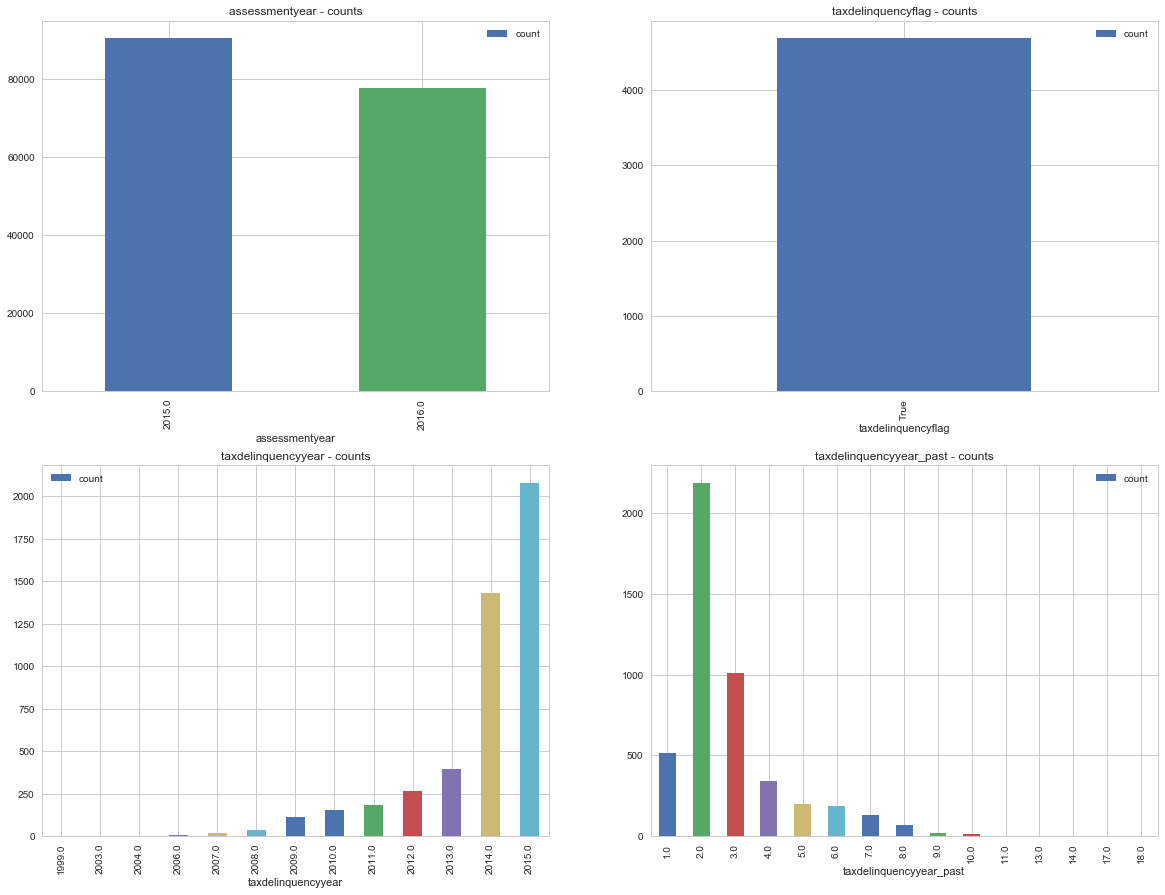

In [146]:
plt.figure(figsize=(20,15))

# Graph for assessmentyear - counts
ax1 = plt.subplot2grid((2,2), (0,0))
assessmentyear.plot(x = 'assessmentyear', y = 'count', kind = 'bar', ax=ax1)
ax1.set_title('assessmentyear - counts')

# Graph for taxdelinquencyflag - counts
ax2 = plt.subplot2grid((2,2), (0,1))
taxdelinquencyflag.plot(x = 'taxdelinquencyflag', y = 'count', kind = 'bar', ax=ax2)
ax2.set_title('taxdelinquencyflag - counts')

# Graph for taxdelinquencyyear - counts
ax3 = plt.subplot2grid((2,2), (1,0))
taxdelinquencyyear.plot(x = 'taxdelinquencyyear', y = 'count', kind = 'bar', ax=ax3)
ax3.set_title('taxdelinquencyyear - counts')

# Graph for taxdelinquencyyear_past - counts
ax4 = plt.subplot2grid((2,2), (1,1))
taxdelinquencyyear_past.plot(x = 'taxdelinquencyyear_past', y = 'count', kind = 'bar', ax=ax4)
ax4.set_title('taxdelinquencyyear_past - counts')

plt.show()

### 2.4 Relationship between Logerror and variables

#### **1) 집의 위치, 지역 등 지리정보와 관련된 변수들**
- 전체 리스트: fips, latitude, longitude, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood

In [ ]:
# 위도 경도에 따른 logerror: logerror가 크면 밝은 색, 작으면 어두운 색
plt.figure(figsize=(16,16))
plt.scatter(x=merged.latitude.values, y=merged.longitude.values, c=merged.logerror.values, cmap=mpl.cm.bone, s=20)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [ ]:
geo_cat = ["fips", "regionidcounty", "raw_census_1", "census_1", "raw_census_2", "census_2",
           "raw_census_3", "census_3", "regionidcity", "regionidzip", "regionidneighborhood"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

In [ ]:
df = merged.loc[:,["raw_census_3","logerror"]]
plt.figure(figsize=(10,6))
sns.boxplot(x = df["raw_census_3"], y = df["logerror"])
# sns.stripplot(x = df["raw_census_3"], y = df["logerror"], jitter = True)
plt.show()

#### **2) 건물 특징, 타입 등에 대한 변수들**
- 전체 리스트: architecturalstyletypeid, decktypeid, buildingqualitytypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid, propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

In [ ]:
bdg_cat =  ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
           "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc", "propertyzoningdesc_1"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

#### **3) 집 구조 등에 대한 변수들**
- 전체 리스트: bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt 

In [ ]:
strt_var = ["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt", "numberofstories", "roomcnt", "bedroomcnt", "unitcnt"]

fig, ax = plt.subplots(2,4, figsize = (20,20))

for idx, n in enumerate(strt_var):
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx // 4,idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    continue

In [ ]:
df = merged.loc[:,["numberofstories","logerror"]]
plt.figure(figsize=(10,4))
sns.boxplot(x = df["numberofstories"], y = df["logerror"])
# sns.stripplot(x = df["raw_census_3"], y = df["logerror"], jitter = True)
plt.show()

In [ ]:
df = merged.loc[:,["yearbuilt","logerror"]]
plt.figure(figsize=(10,4))
sns.boxplot(x = df["yearbuilt"], y = df["logerror"])
# sns.stripplot(x = df["raw_census_3"], y = df["logerror"], jitter = True)
plt.show()

In [ ]:
yearbuilt_plot = sns.jointplot(x = "yearbuilt", y = "logerror", data=merged, kind="reg")
yearbuilt_plot.fig.set_size_inches(10,6)

#### **4) 집의 기타 특징(유틸리티 등)에 대한 변수들**
- 전체 리스트: heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, fireplacecnt, fireplaceflag, poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7
- "poolsizesum"을 빼고 묶어 살펴봄

In [ ]:
utl_cat = ["heatingorsystemtypeid", "airconditioningtypeid", "hashottuborspa", "fireplacecnt", "fireplaceflag", "poolcnt", 
           "pooltypeid10", "pooltypeid2", "pooltypeid7"]

fig, ax = plt.subplots(3, 3, figsize = (20, 20))

for idx, n in enumerate(utl_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 3, idx % 3])
    ax[idx // 3, idx % 3].set(yticklabels=[])
    ax[idx // 3, idx % 3].set(xticklabels=[])
    continue

In [ ]:
plot = sns.jointplot(x = "poolsizesum", y = "logerror", data=merged, kind="reg")
plot.fig.set_size_inches(10,6)

#### **5) 집의 면적에 대한 변수들**

In [ ]:
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

fig, ax = plt.subplots(4,4, figsize = (20,20))

for idx, n in enumerate(sqft_vars):
    if n == 'logerror':
        continue
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//4,idx%4])
    ax[idx//4, idx%4].set(yticklabels=[])
    ax[idx//4, idx%4].set(xticklabels=[])
    continue

#### **6) tax와 관련된 변수들**

In [ ]:
tax_var = ['taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag']

fig, ax = plt.subplots(2,3, figsize = (12,8))

for idx, n in enumerate(tax_var):
    if n == 'logerror':
        continue
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//3,idx%3])
    ax[idx//3, idx%3].set(yticklabels=[])
    ax[idx//3, idx%3].set(xticklabels=[])
    continue

##### assessmentyear 와 logerror의 관계

In [ ]:
sns.barplot(x = 'assessmentyear', y='logerror', data = merged)

##### taxdelinquencyyear 와 logerror의 관계

In [ ]:
sns.barplot(x = 'taxdelinquencyyear', y='logerror', data = merged.sort_values(by='taxdelinquencyyear'))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.boxplot(x = "taxdelinquencyyear", y = "logerror", data=merged)
plt.show()

## **3. Feature Engineering**

### 3.1 Missing Values

#### 3.1.1 Status of missing values
- 데이터에 missing value가 상당히 많음, missing value의 비중을 높은 순으로 살펴보자

In [ ]:
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

In [ ]:
merged_missing.sort_values(by = "missing_ratio", ascending = True).plot(kind = 'barh', figsize=(12,20))

##### Comment:
- missing value ratio가 매우 높은 변수들이 많음
- missing value imputation 방안
    - NaN은 실제로 없어서 그런 것이라고 간주: 0사용
    - 자료가 missing 된 것이라고 볼 경우
        - 연속형 변수: 평균 사용
        - 이산형 변수, 카테고리 변수: 최빈값 사용

#### 3.1.3 Missing Values processing

In [ ]:
## 일부 변수 추가 후 categorical / numerical 새로 분류
    ## poolcnt는 dummy variable로 재분류함 (1, 0)

In [ ]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate','rawcensustractandblock', 'censustractandblock', "raw_census_1", "census_1",
            "raw_census_2", "census_2", "raw_census_3", "census_3", 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidzip',
            'regionidneighborhood', 'architecturalstyletypeid', 'decktypeid', 'buildingqualitytypeid', 'buildingclasstypeid',
            'storytypeid', 'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', "propertyzoningdesc_1", 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag', 'pooltypeid10', 'pooltypeid2',
            'pooltypeid7', 'poolcnt']
num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

In [ ]:
merged_1 = merged.copy()
merged_1.tail()

#### (1) numerical variables:

##### 집 면적에 관련된 실수 변수
- imputation을 어떻게 할 거라는 설명!

In [ ]:
## 위에 한꺼번에 그래프 그리는 부분에서 한번 정의 해준 부분인데 다시 확실히
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

In [ ]:
def processing_feet_dfX_MV():
    for feature in sqft_vars:
        if feature == 'garagecarcnt':
            merged_1[feature] = merged_1[feature].fillna(1)
        elif feature == 'garagetotalsqft':
            merged_1["garagetotalsqft"] = \
            merged_1["garagetotalsqft"].fillna(float("{:.1f}".format(merged_des.loc['garagetotalsqft'].loc['mean'])))
        else:
            merged_1[feature] = merged_1[feature].fillna(0)

In [ ]:
processing_feet_dfX_MV()

##### tax에 관련된 실수 변수? (MV ratio가 낮은 것들이었나?)

##### 지리, 건물 특성 변수 중 missing value ratio가 높은 것 (5% 이상인 것)
- buildingqualitytypeid: 평균점수에 가까우면서 최빈값인 7로 imputation

In [ ]:
merged_1["buildingqualitytypeid"] = merged_1["buildingqualitytypeid"].fillna(7)

##### 집 구조, 유틸 등에 대한 numerical variable

In [ ]:
merged_1["numberofstories"] = merged_1["numberofstories"].fillna(1)
merged_1["roomcnt"] = merged_1["roomcnt"].fillna(1)
merged_1["bedroomcnt"] = merged_1["bedroomcnt"].fillna(3)
merged_1["unitcnt"] = merged_1["unitcnt"].fillna(1)
merged_1["fireplacecnt"] = merged_1["fireplacecnt"].fillna(0)
merged_1["poolsizesum"] = merged_1["poolsizesum"].fillna(0)

#### (2) dummy/categorical variables:

In [ ]:
cat_vars

##### 지리, 건물 특성 관련 카테고리 변수 중 missing value ratio가 높은 것 (5% 이상인 것)
- regionidneighborhood (0.601008): 위치한 동네 ㅡ 무엇으로 imputation을 할 수 있나?
- architecturalstyletypeid: 최빈값인 7로 imputation
- decktypeid: NaN은 deck이 없다고 간주. 0으로 imputation → 더미변수화
- buildingclasstypeid: 최빈값인 4로 imputation
- storytypeid: 나온 값이 7 하나 뿐. 모두 7로 imputation → 변수의 의미가 없어짐
- typeconstructiontypeid: 최빈값인 6으로 imputation
- propertycountylandusecode: 최빈값인 0100으로 imputation
- propertylandusetypeid: 최빈값인 261로 imputation
- propertyzoningdesc: 최빈값인 LAR1로 imputation
- propertyzoningdesc_1: 최빈값인 L로 imputation

In [ ]:
# ls_c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
#              'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'taxdelinquencyyear',
#              'assessmentyear', 'heatingorsystemtypeid', 'airconditioningtypeid']

In [ ]:
merged_1["architecturalstyletypeid"] = merged_1["architecturalstyletypeid"].fillna('7')
merged_1["decktypeid"] = merged_1["decktypeid"].fillna(0)
merged_1["decktypeid"] = merged_1["decktypeid"].replace(['66.0'], 1)
merged_1["buildingclasstypeid"] = merged_1["buildingclasstypeid"].fillna('4.0')
merged_1["storytypeid"] = merged_1["storytypeid"].fillna('7.0')
merged_1["typeconstructiontypeid"] = merged_1["buildingclasstypeid"].fillna('6.0')
merged_1["propertycountylandusecode"] = merged_1["propertycountylandusecode"].fillna('0100')
merged_1["propertylandusetypeid"] = merged_1["propertylandusetypeid"].fillna('261.0')
merged_1["propertyzoningdesc"] = merged_1["propertyzoningdesc"].fillna('LAR1')
merged_1["propertyzoningdesc_1"] = merged_1["propertyzoningdesc_1"].fillna('L')

##### 집 구조, 유틸 등에 대한 카테고리 변수
- poolcnt는 더미변수화 시킴

In [ ]:
merged_1["heatingorsystemtypeid"] = merged_1["heatingorsystemtypeid"].fillna(2)
merged_1["airconditioningtypeid"] = merged_1["airconditioningtypeid"].fillna(1)
merged_1["poolcnt"] = merged_1["poolcnt"].fillna(0)
merged_1["fireplaceflag"] = merged_1["fireplaceflag"].fillna(0)
merged_1["pooltypeid10"] = merged_1["pooltypeid10"].fillna(0)
merged_1["pooltypeid2"] = merged_1["pooltypeid2"].fillna(0)
merged_1["pooltypeid7"] = merged_1["pooltypeid7"].fillna(0)
merged_1["ppoolsizesum"] = merged_1["poolsizesum"].fillna(0)
merged_1["hashottuborspa"] = merged_1["hashottuborspa"].fillna(0)
merged_1["threequarterbathnbr"] = merged_1["threequarterbathnbr"].fillna(0)

##### 집 면적, tax에 관련된 카테고리 변수
- 

In [ ]:
merged_1['taxdelinquencyflag'] = merged_1['taxdelinquencyflag'].fillna(0)
merged_1["taxdelinquencyyear"] = merged_1["taxdelinquencyyear"].fillna(0)
merged_1["taxdelinquencyyear_past"] = merged_1["taxdelinquencyyear_past"].fillna(0)

#### 상범님 추가적인 작업 부분?

In [ ]:
merged["heatingorsystemtypeid"]

In [ ]:
df = pd.DataFrame(columns=["Original","Yes","None"])
df["Original"] = merged["heatingorsystemtypeid"]
df

In [ ]:
df["None"] = df[df["Original"] == 13.0]["Original"]
df2 = df[df["None"] == 13.0]
df2

In [ ]:
df2 = df[df["Original"] == 13]
df2

In [ ]:
df.columns[2]

In [ ]:
df2 = df[np.isnan(df["Original"])]
df2["None"] = 1.0
df2

#### (3) imputation 후 missing value ratio 다시 체크

In [ ]:
merged_1_des = merged_1.describe(include='all').transpose()
merged_1_des["missing_ratio"] = 1-(merged_1_des["count"]/merged_1.shape[0])
merged_1_des["dtype"] = merged_1.dtypes
merged_1_missing = pd.DataFrame(merged_1_des["missing_ratio"].sort_values(ascending=False))
merged_1_missing.reset_index()

### 3.2 Feature Correlation

#### 3.2.1 Numerical Features

In [ ]:
num_df = merged_1[num_vars]

In [ ]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette("purple", as_cmap=True)
sns.heatmap(num_df.corr(), annot=True, fmt='3.2f', cmap=cmap)
plt.show()

#### 3.2.2 Categorical Features

In [ ]:
cat_df = merged_1[cat_vars]

### 3.3 Determination of outliers and variables using OLS model

#### 3.3.1 Model by all numerical Features

#### 3.3.2 Model by all categorical Features

#### 3.3.3 Model by numerical and categorical features together

#### 3.3.4 Model by high correlation coefficient numerical features with Logerror

#### 3.3.5 Model by high correlation coefficient numerical features and categorical features 

#### 3.3.6 Multi-collinearity and variance analysis between variables

##### (1) Multi-collinearity

##### (2) Analysis of variance on categorical features

#### 3.3.7 Comparison of model performance by using variables

### 3.4 Outlier

#### 1) Option1 : IQR (Interquartile Range)

#### 2) Option2 : Standardized resids

#### 3) Option3 : Cook's Distance

#### 4) Check all outliers (option 1,2,3)

#### 5) Combination of outliers groups

### 3.5 Data preprocessing

#### 3.5.1 Select numerical variables

#### 3.5.2 Select categorical variables

## **4. Modeling**

### 4.1. Input data

### 4.2 OLS(Ordinary Least Square) Model

#### 4.2.1 Make OLS Model

#### 4.2.2 ANOVA F-test

#### 4.2.3 RMSE

#### 4.2.4 Normalization of residuals

### 4.3 Predict Logerror